# Can the distance to the nearest hospital predict HH Expenditures in Malawi? 

In [94]:
import pandas as pd
import numpy as np

from osmnx.core import overpass_request
from shapely.geometry import Point
import geopandas as gpd
import mapclassify

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

In [95]:
!mkdir Data
!mkdir Data/WB_Survey/
!mkdir Data/OSM/

mkdir: Data: File exists
mkdir: Data/WB_Survey/: File exists
mkdir: Data/OSM/: File exists


### 1. Preparing the Survey Data

In [96]:
# We will work with the World Bank Malawi Integrated Household Panel Survey 2013 Round.
# The micro data is available online upon registration

In [97]:
# First step is to download the survey data from the WB site. We have to register first and provide details on how the data will be used.

# The two files needed are:
# - Round 2 (2013) Consumption Aggregate.dta
# - HouseholdGeovariables_IHPS_13.dta

# https://microdata.worldbank.org/index.php/catalog/2248/data-dictionary

In [98]:
micro_exp = pd.read_stata("Data/WB_Survey/Round 2 (2013) Consumption Aggregate.dta", columns=["y2_hhid","ea_id","rexpagg","adulteq","hhsize"])

# Calculate total expenditures per capita per day
micro_exp["exp"] = micro_exp["rexpagg"] / (micro_exp["adulteq"] * 365) 

micro_gps = pd.read_stata("Data/WB_Survey/HouseholdGeovariables_IHPS_13.dta", columns=["y2_hhid","LON_DD_MOD","LAT_DD_MOD"])

# We merge the GPS coordinates. Note that these are modifiued cluster/ea GPS coordinates.
micro = micro_exp.merge(micro_gps, on='y2_hhid')

# We group by cluster and compute the median expenditure to handle outliers
hh_data = micro.groupby("ea_id")[["exp","LON_DD_MOD","LAT_DD_MOD"]].median()
hh_data["n"] = micro.groupby("ea_id").size()
hh_data = hh_data.reset_index()
hh_data.columns=["ea_id","exp","gpsLongitude","gpsLatitude", "n"]

In [99]:
hh_data.describe()

,exp,gpsLongitude,gpsLatitude,n
count,204.000000,204.000000,204.000000,204.000000
mean,461.054486,34.413049,-13.878116,19.607843
std,375.455942,0.732449,1.825520,2.863588
min,188.449059,32.986300,-16.985500,12.000000
25%,317.965676,33.778800,-15.401200,18.000000
50%,394.836447,34.188900,-14.067400,19.000000
75%,482.178505,35.105050,-13.034200,21.000000
max,4562.132762,35.806700,-9.504460,28.000000


In [100]:
hh_data.head()

,ea_id,exp,gpsLongitude,gpsLatitude,n
0,10101016,222.118845,33.3873,-9.80998,16
1,10101204,235.791353,33.3810,-9.89498,17
2,10101215,328.086215,33.2302,-9.50446,17
3,10101562,274.424699,33.3937,-9.66792,22
4,10102004,188.449059,33.5035,-9.74823,16


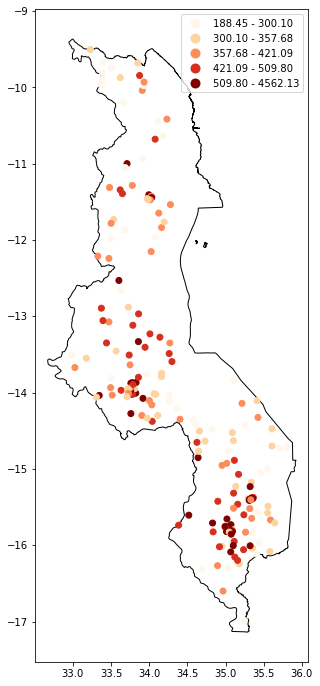

In [101]:
# Let's visualise our survey data
hh_data_gdf = gpd.GeoDataFrame(
    hh_data, geometry=gpd.points_from_xy(hh_data.gpsLongitude, hh_data.gpsLatitude))

# We import the boundaries of Malawi (geojson format)
url_Mlw = "https://raw.githubusercontent.com/krisajenkins/hack-malawi/master/resources/public/json/malawi.geojson"
Mlw_shp = gpd.read_file(url_Mlw)

ax = Mlw_shp.plot(color='white', edgecolor='black', figsize=(12, 12))

hh_data_gdf.plot(column='exp', ax=ax, legend=True, cmap='OrRd', scheme='quantiles')

### 2. Calculate the distance to the nearest hospital

In [102]:
# We download the GPS locations of all the hospitals in Malawi from OpenStreetMap using the OverPass API.
# A nice interface to the API is the OMNx module

In [103]:
# We specify the GPS coordinates of the AOI (BBox)
minlon = hh_data['gpsLongitude'].min() - 1
maxlon = hh_data['gpsLongitude'].max() + 1
minlat = hh_data['gpsLatitude'].min() - 1
maxlat = hh_data['gpsLatitude'].max() + 1

In [104]:
tag_key = 'amenity'
tag_value = 'hospital'

In [105]:
query_osm = ('[out:json][maxsize:2000000000];'
             '('
             'node["{tag_key}"="{tag_value}"]({minlat:.8f},{minlon:.8f},{maxlat:.8f},{maxlon:.8f});'
             ');(._;>;);out center;'
             ).format(minlat=minlat, maxlat=maxlat, minlon=minlon, maxlon=maxlon, tag_key=tag_key, tag_value=tag_value)


response_json = overpass_request(data={'data': query_osm}, timeout=10000, error_pause_duration=None)

In [106]:
# Number of downloaded elements
print(len(response_json['elements']))

192


In [107]:
# Convert the JSON into a GeoDataFrame. An element can be a point or a polygon. In the later case we take the center as our GPS point/
points = []

for result in response_json['elements']:
    if 'type' in result and result['type'] == 'node':
        p = Point([(result['lon'], result['lat'])])
        point = {'geometry': p}
        points.append(point)
    if 'type' in result and result['type'] == 'way':
        p = Point([(result['center']['lon'], result['center']['lat'])])
        point = {'geometry': p}
        points.append(point)
        
osm_gdf = gpd.GeoDataFrame(points)
osm_gdf.crs = {'init': 'epsg:4326'}

# We export it in a SHP file to visualize in QGIS
osm_gdf.to_file("Data/OSM/location_{}_{}.shp".format(tag_key, tag_value), driver='ESRI Shapefile')

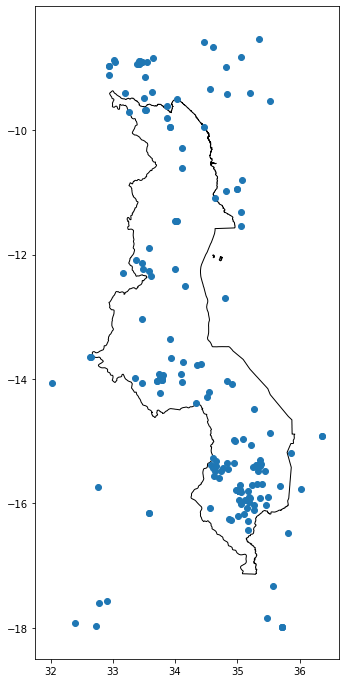

In [108]:
# Let's plot the hospitals
ax = Mlw_shp.plot(color='white', edgecolor='black', figsize=(12, 12))
osm_gdf.plot(ax=ax)

In [109]:
# Some of the hospitals are outside the boundaries of Malawi
hospitals_within_Mlw = gpd.sjoin(osm_gdf, Mlw_shp, how="inner", op='intersects')

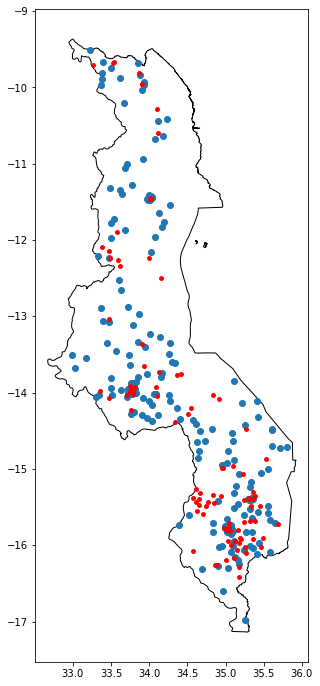

In [110]:
# Let's plot the hospitals and the survey data together
ax = Mlw_shp.plot(color='white', edgecolor='black', figsize=(12, 12))
hh_data_gdf.plot(ax=ax)
hospitals_within_Mlw.plot(ax=ax, color='red', markersize=15)

In [111]:
# The default distance function available in Sklearn Neareasrt Neighbor Algorithm is Euclidian distance, for more precision, 
# we introduce the haversine distance (at the Earth surface)

def distance(p1, p2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = p1
    lon2, lat2 = p2
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6356.75 * c # Radius of the earth on the Equator
    return km

In [112]:
# Nearest Neighbor algorithms can be computationnaly expensive. Sklearn provides an index search methods that partitions the space 
# into multiple boxes (Tree data structure) which considerably speeds up the nearest neighbor search for large datasets.

gdf_lats = gdf["geometry"].y
gfd_lons = gdf["geometry"].x

X = np.array([gdf_lats, gfd_lons]).T

nbrs = NearestNeighbors(n_neighbors=1, metric=distance).fit(X)
features = []

In [113]:
latitudes = hh_data["gpsLatitude"]
longitudes = hh_data["gpsLongitude"]

for lat, lon in zip(latitudes, longitudes):
    x = np.array([[lat, lon]])
    a, _ = nbrs.kneighbors(x)
    features.append(a[[0]][0][0])

hh_data["distance"] = features

In [114]:
# We also export the survey data to a Shapefile
gdf2 = gpd.GeoDataFrame(hh_data, geometry=gpd.points_from_xy(hh_data["gpsLongitude"], hh_data["gpsLatitude"]))
gdf2.crs = {'init': 'epsg:4326'}
gdf2.to_file("Data/WB_Survey/survey_cluster.shp", driver='ESRI Shapefile')

In [115]:
# We check the average and min, max distance in kms to the nearest facility
hh_data["distance"].describe()

count    204.000000
mean      14.075085
std       12.984319
min        0.077546
25%        3.797965
50%       10.102974
75%       20.897093
max       55.378697
Name: distance, dtype: float64

### 3. Build a prediction model

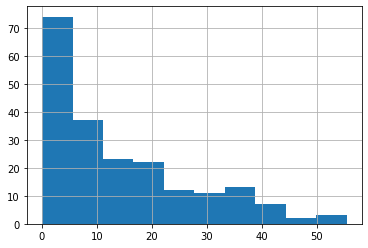

In [116]:
hh_data["distance"].hist()

In [117]:
y = hh_data["exp"].values
# The y distribution is vagually log-normal so we take the log.
y = np.log(y)

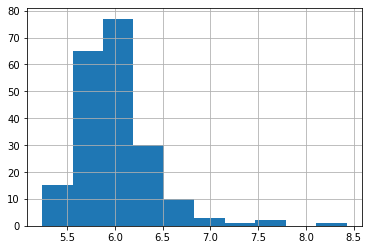

In [118]:
pd.Series(y).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123ad08d0>]],
      dtype=object)

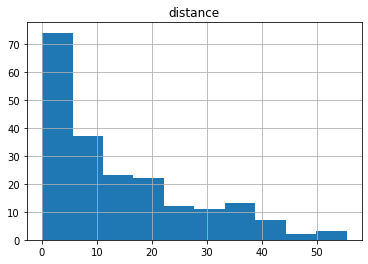

In [119]:
hh_data[["distance"]].hist()

In [120]:
# Same, the data is skewed to we take the log
hh_data["log_distance"] = hh_data["distance"].apply(np.log)

In [121]:
X = hh_data[["log_distance"]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1245aadd8>]],
      dtype=object)

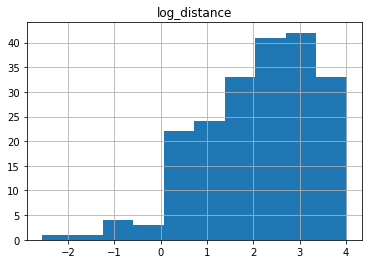

In [122]:
X.hist()

In [134]:
# We consider a simple Linear Regression Model
model = LinearRegression()

# The data is sorted so it is important to shuffle the records
cv = KFold(n_splits=5, shuffle=True, random_state=485934)

# To assess the precision and accuracy of our model, we compute the R2 score using 5-fold cross validation
R2 = cross_val_score(model, X, y, cv=cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (R2.mean(), R2.std() * 2))

R2: 0.15 (+/- 0.35)


In [124]:
# With a complexed Transfer Learning method using a convolutional neural network on High Resolution Satellite Images, Neal Jean
# obtains a R2 of 0.37 on the same dataset. See: https://science.sciencemag.org/content/353/6301/790

### 4. What about the NDVI index?

In [147]:
## Let's use the Google Earth Engine API to compute NDVI
import ee 
from datetime import datetime as dt
from IPython.display import Image

In [148]:
## Initialize connection to server
ee.Initialize()

landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

# We filter by the survey year 
landsat = landsat.filterDate('2013-01-01','2013-12-31')

bbox = ee.Geometry.Rectangle([minlon, minlat, maxlon, maxlat])
region = bbox.getInfo()

landsat_AOI = landsat.filterBounds(region)
landsat_mosaic = ee.Image(landsat_AOI.sort('CLOUD_COVER', False).mosaic())

parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': region}
 
#A Mosaic image of Landsat data over our AOI
Image(url = landsat_mosaic.getThumbUrl(parameters))

In [149]:
def addIndices(image):
        ndvi = image.normalizedDifference(['B5', 'B4'])
        return ndvi
    
ndvi = ee.Image(landsat_AOI.map(addIndices).reduce("max"))

palette = ['red', 'yellow', 'green']

ndvi_parameters = {'min': 0,
                   'max': 1,
                   'dimensions': 512,
                   'palette': palette,
                   'region': region}

#The Max NDVI in 2013 over our AOI
Image(url = ndvi.getThumbUrl(ndvi_parameters))

In [150]:
def get_NDVI(lon, lat):
    point = ee.Geometry.Point(lon, lat) #longitude, latitude

    # filter area
    landsat_AOI = landsat.filterBounds(point)

    ndvi = ee.Image(landsat_AOI.map(addIndices).reduce("max"))

    value = ndvi.reduceRegion(reducer=ee.Reducer.first(), geometry=ee.Geometry.Point(lon, lat), scale=30, maxPixels=1)

    return value.getInfo()["nd_max"]

In [151]:
max_NDVI = hh_data.apply(lambda x: get_NDVI(x.gpsLongitude, x.gpsLatitude), axis=1)

In [152]:
hh_data['max_NDVI'] = max_NDVI

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1247ca128>]],
      dtype=object)

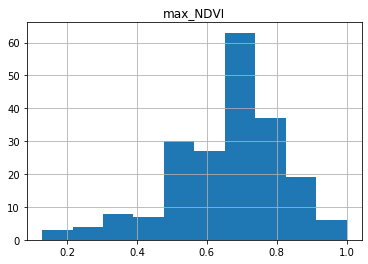

In [153]:
hh_data[['max_NDVI']].hist()

In [154]:
X = hh_data[["max_NDVI"]]

R2 = cross_val_score(model, X, y, cv=cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (R2.mean(), R2.std() * 2))

R2: -0.07 (+/- 0.14)


In [155]:
X = hh_data[["log_distance", "max_NDVI"]]

R2 = cross_val_score(model, X, y, cv=cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (R2.mean(), R2.std() * 2))

R2: 0.15 (+/- 0.35)
